# Predictive Modelling

### ---- Define the problem ----


The aim of this project is to build a model which can precisely predict the salary of new job advertisement based on the historical data. It is important to understand what factors contribute most in predicting the salary and relationship between salary and dependent variables.


In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplot
import seaborn as sns
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import Binarizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [2]:
#load csv data files 

def load_file(file):
    return pd.read_csv(file)

#merge data
def merge_data(df1, df2, key):
    return df1.merge(df2, on = key)

#clean data function
def clean_data(df):
    #removes rows where salary equals to zero
    return df[df.salary > 0]
#one hot encoding to transform categorical to dummy 

def plot_feature(df, col):
    plt.figure(figsize = (14, 6))
    plt.subplot(1, 2, 1)
    if df[col].dtype == 'int64':
        df[col].value_counts().sort_index().plot()
    else:
        #change the categorical variable to category type and order their level by the mean salary
        #in each category
        mean = df.groupby(col)['salary'].mean()
        df[col] = df[col].astype('category')
        levels = mean.sort_values().index.tolist()
        df[col].cat.reorder_categories(levels, inplace=True)
        df[col].value_counts().plot()
    plt.xticks(rotation=45)
    plt.xlabel(col)
    plt.ylabel('Counts')
    plt.title('Distribution of {}'.format(col))
    plt.subplot(1, 2, 2)
    
    if df[col].dtype == 'int64' or col == 'companyId':
        #plot the mean salary for each category and fill between the (mean - std, mean + std)
        mean = df.groupby(col)['salary'].mean()
        std = df.groupby(col)['salary'].std()
        mean.plot()
        plt.fill_between(range(len(std.index)), mean.values-std.values, mean.values + std.values, \
                         alpha = 0.1)
    else:
        sns.boxplot(x = col, y = 'salary', data=df.sort_values('salary'))
    
    plt.xticks(rotation=45)
    plt.ylabel('Salaries')
    plt.title('Relationship of Salary with {}'.format(col))
    plt.show()
    
def encode_label(df, col):
    cat_dict ={}
    cats = df[col].cat.categories.tolist()
    for cat in cats:
        cat_dict[cat] = df[df[col] == cat]['salary'].mean()   
    df[col] = df[col].map(cat_dict)
    
def one_hot_encode(df, cat_vars=None, num_vars=None):
    cat_df = pd.get_dummies(df[cat_vars])
    num_df = df[num_vars].apply(pd.to_numeric)
    return pd.concat([cat_df, num_df], axis=1)
    
def train_model(model, feature_df, target_df, num_procs, mean_mse, cv_std):
    neg_mse = cross_val_score(model, feature_df, target_df, cv=2, n_jobs=num_procs, scoring='neg_mean_squared_error')
    mean_mse[model] = -1.0*np.mean(neg_mse)
    cv_std[model] = np.std(neg_mse)

def print_summary(model, mean_mse, cv_std):
    print('\nModel:\n', model)
    print('Average MSE:\n', mean_mse[model])
    print('Standard deviation during CV:\n', cv_std[model])

def save_results(model, mean_mse, predictions, feature_importances):
    '''saves model, model summary, feature importances, and predictions'''
    with open('model.txt', 'w') as file:
        file.write(str(model))
    feature_importances.to_csv('feature_importances.csv') 
    np.savetxt('predictions.csv', predictions, delimiter=',')

## DISCOVER

#Load the data 

In [3]:
!ls -lh data/

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
train_feature = load_file(r'C:\Users\Bal\Documents\ADM\1 Python\Salary\Predictive Modelling/train_features.csv')
train_salary = load_file(r'C:\Users\Bal\Documents\ADM\1 Python\Salary\Predictive Modelling/train_salaries.csv')
test_set = load_file(r'C:\Users\Bal\Documents\ADM\1 Python\Salary\Predictive Modelling/test_features.csv')

In [5]:
print('The shape of the test set is {}'.format(test_set.shape))

The shape of the test set is (1000000, 8)


In [6]:
print('The shape of the train_feature is {}'.format(train_feature.shape))

The shape of the train_feature is (1000000, 8)


In [7]:
print('The shape of the train_salary is {}'.format(train_salary.shape))

The shape of the train_salary is (1000000, 2)


#Data Preprocessing 

In [9]:
# Inspect any missing data
train_feature.isnull().any()

jobId                  False
companyId              False
jobType                False
degree                 False
major                  False
industry               False
yearsExperience        False
milesFromMetropolis    False
dtype: bool

In [10]:
train_salary.isnull().any()

jobId     False
salary    False
dtype: bool

In [11]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
jobId                  1000000 non-null object
companyId              1000000 non-null object
jobType                1000000 non-null object
degree                 1000000 non-null object
major                  1000000 non-null object
industry               1000000 non-null object
yearsExperience        1000000 non-null int64
milesFromMetropolis    1000000 non-null int64
dtypes: int64(2), object(6)
memory usage: 61.0+ MB


In [12]:
train_feature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
jobId                  1000000 non-null object
companyId              1000000 non-null object
jobType                1000000 non-null object
degree                 1000000 non-null object
major                  1000000 non-null object
industry               1000000 non-null object
yearsExperience        1000000 non-null int64
milesFromMetropolis    1000000 non-null int64
dtypes: int64(2), object(6)
memory usage: 61.0+ MB


In [13]:
train_salary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
jobId     1000000 non-null object
salary    1000000 non-null int64
dtypes: int64(1), object(1)
memory usage: 15.3+ MB


In [14]:
# Merging the dataset train_salary and train_fea
train_merged = pd.merge(train_feature,train_salary, how='left', on='jobId')

In [15]:
# Look for duplicated values.
train_merged.duplicated().any()

False

In [16]:
#define variables
categorical_vars = [ 'jobType', 'degree', 'major', 'industry']
numeric_vars = ['yearsExperience', 'milesFromMetropolis']
target_var = 'salary'

#Exploratory Data Analysis 

#Dive deep into the data.
-Does certain major earn a higher salary in specific industry? 
-Does achieving higher education always lead to a higher salary? 


In [17]:
train_merged.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


In [18]:
# Review the summary statistics 
train_merged.describe(include = 'all')

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
count,1000000,1000000,1000000,1000000,1000000,1000000,1000000.000000,1000000.000000,1000000.000000
unique,1000000,63,8,5,9,7,NaN,NaN,NaN
top,JOB1362684677460,COMP39,SENIOR,HIGH_SCHOOL,NONE,WEB,NaN,NaN,NaN
freq,1,16193,125886,236976,532355,143206,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,11.992386,49.529260,116.061818
std,NaN,NaN,NaN,NaN,NaN,NaN,7.212391,28.877733,38.717936
min,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,6.000000,25.000000,88.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,12.000000,50.000000,114.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,18.000000,75.000000,141.000000


In [19]:
# Check if every record are unique
train_merged.jobId.nunique() == len(train_merged)

True

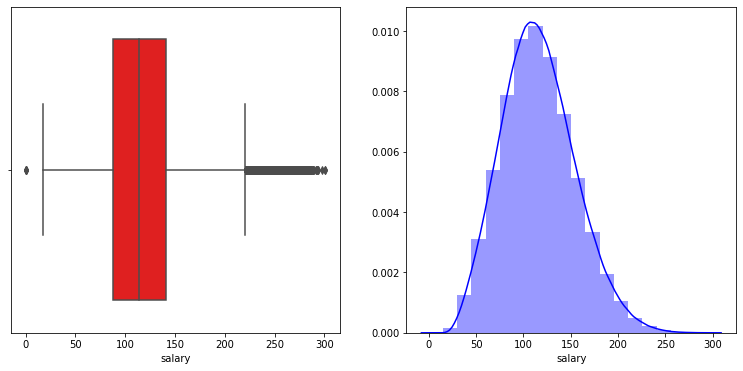

In [20]:
# Check the distribution of the target variable. 
plt.figure(figsize = (13, 6))
plt.subplot(1,2,1)
sns.boxplot(train_merged.salary,color = 'r')
plt.subplot(1,2,2)
sns.distplot(train_merged.salary, bins=20,color = 'b')
plt.show()

In [21]:
train_merged.salary.describe()

count    1000000.000000
mean         116.061818
std           38.717936
min            0.000000
25%           88.000000
50%          114.000000
75%          141.000000
max          301.000000
Name: salary, dtype: float64

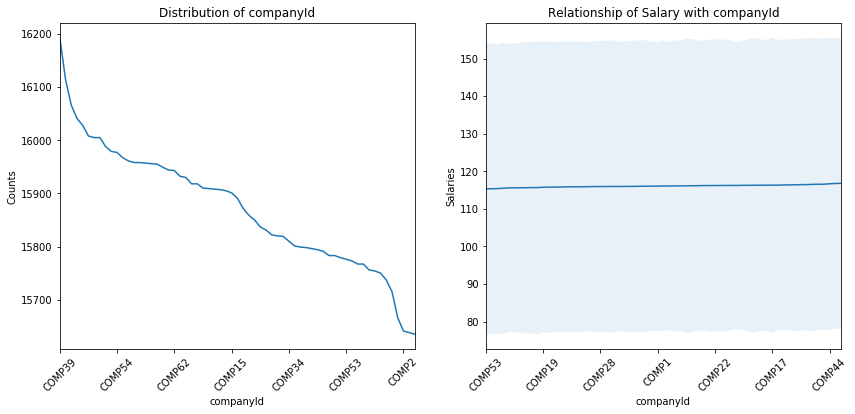

In [22]:
plot_feature(train_merged,'companyId')

##### Company_Id and salary doesn't appear to have a strong relationship

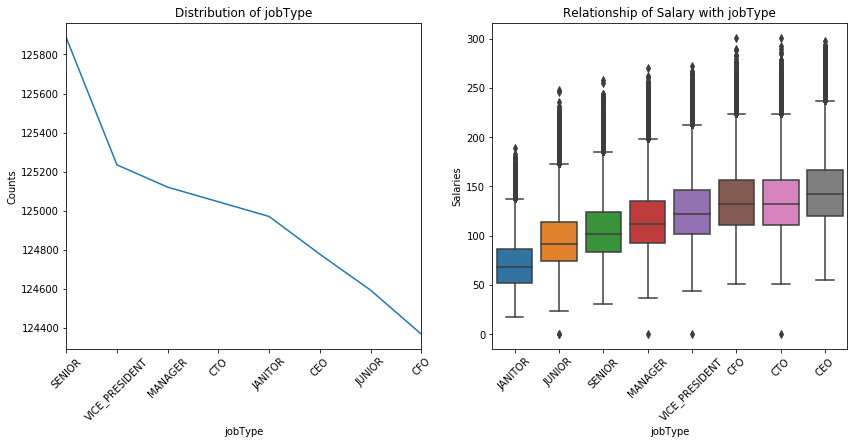

In [23]:
plot_feature(train_merged,'jobType')

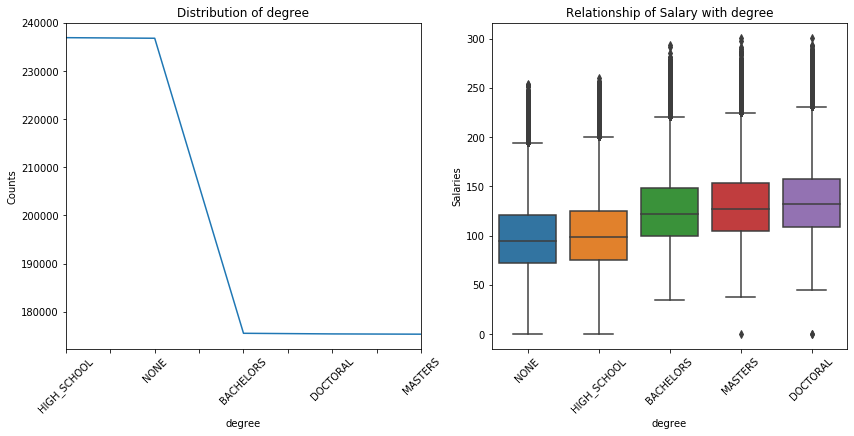

In [24]:
plot_feature(train_merged,'degree')

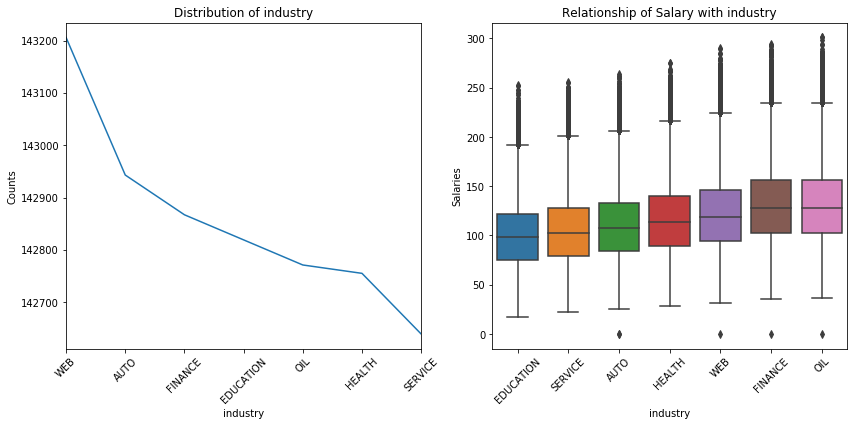

In [25]:
plot_feature(train_merged,'industry')

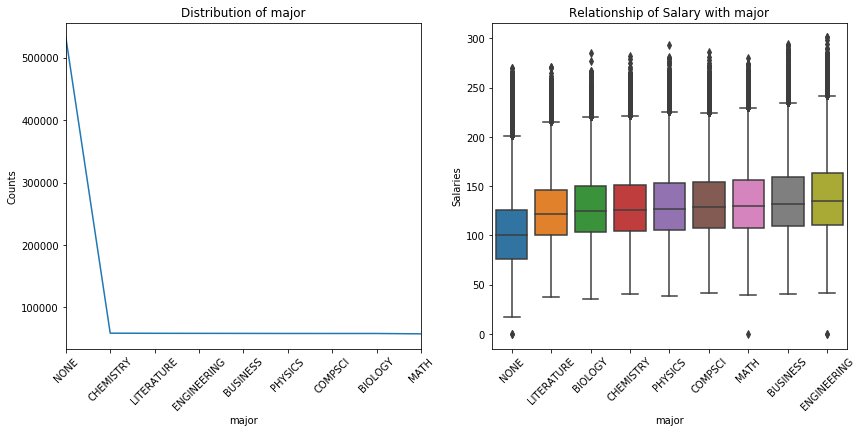

In [26]:
plot_feature(train_merged,'major')

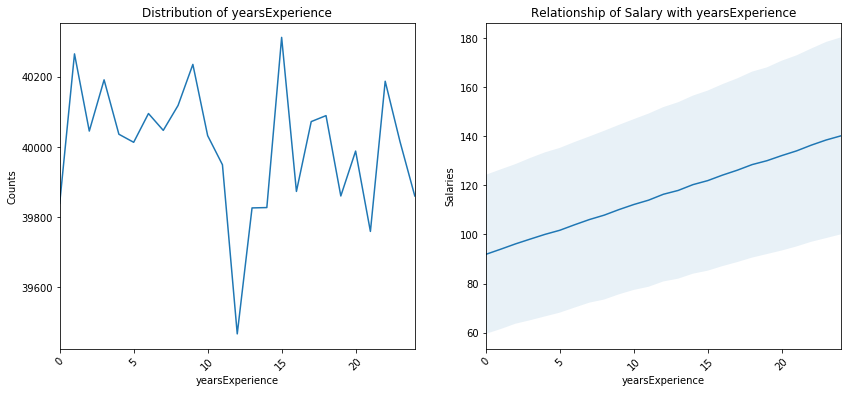

In [27]:
plot_feature(train_merged,'yearsExperience')

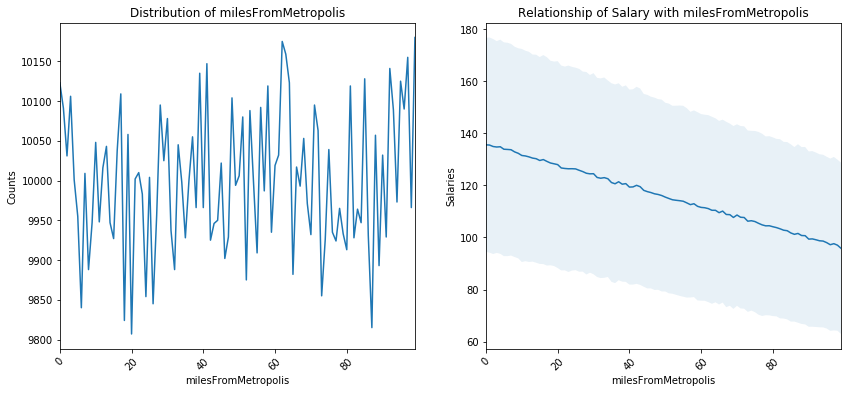

In [28]:
plot_feature(train_merged,'milesFromMetropolis')

#Investigate : Does certain Qualification earn a higher salary in specific industry?       

In [29]:
industry_type = train_merged['industry'].unique()

<Figure size 432x288 with 0 Axes>

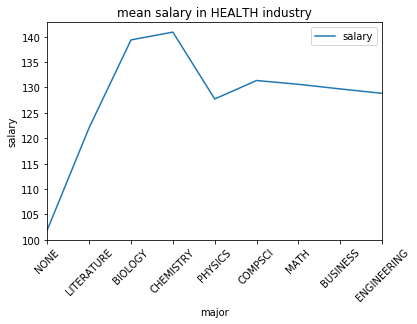

<Figure size 432x288 with 0 Axes>

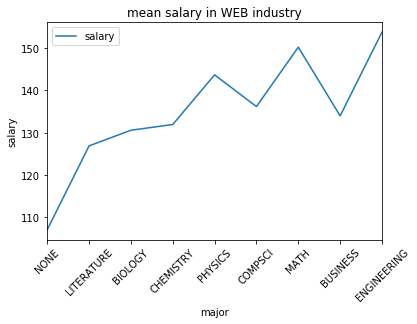

<Figure size 432x288 with 0 Axes>

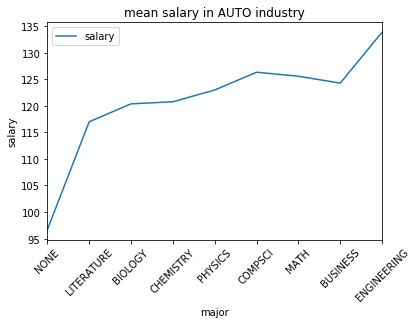

<Figure size 432x288 with 0 Axes>

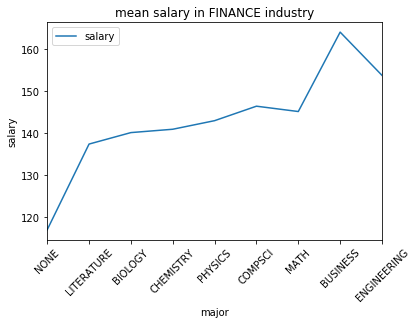

<Figure size 432x288 with 0 Axes>

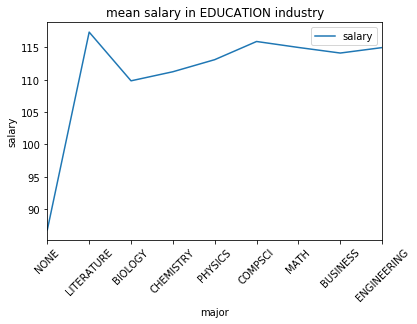

<Figure size 432x288 with 0 Axes>

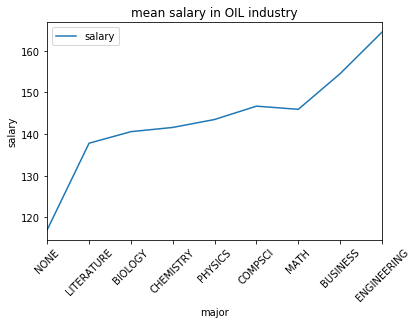

<Figure size 432x288 with 0 Axes>

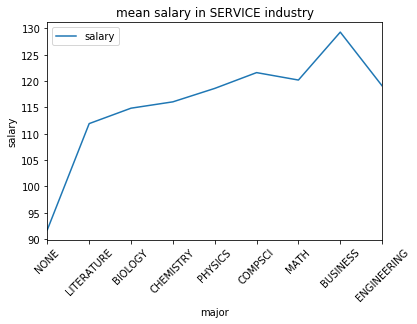

In [30]:
for i  in industry_type:
        plt.figure()
        train_merged[(train_merged['industry'] == i)][['major','salary']].groupby('major').mean().plot()
        plt.title('mean salary in {} industry'.format(i))
        plt.ylabel('salary')
        plt.xticks(rotation=45)
        plt.show()

#Business major has the highest mean salary in the finance industry and service industry. 
#Engineering major has the highest salary in the web, oil, and auto industries. 
#Surprisingly, chemistry major earns more than the biology major in the health space. 

In [31]:
## Copy the dataset for correlation analysis

corr_train = train_merged.copy()

In [32]:
for i in corr_train.columns:
    if corr_train[i].dtype.name=='category':
        encode_label(corr_train,i)

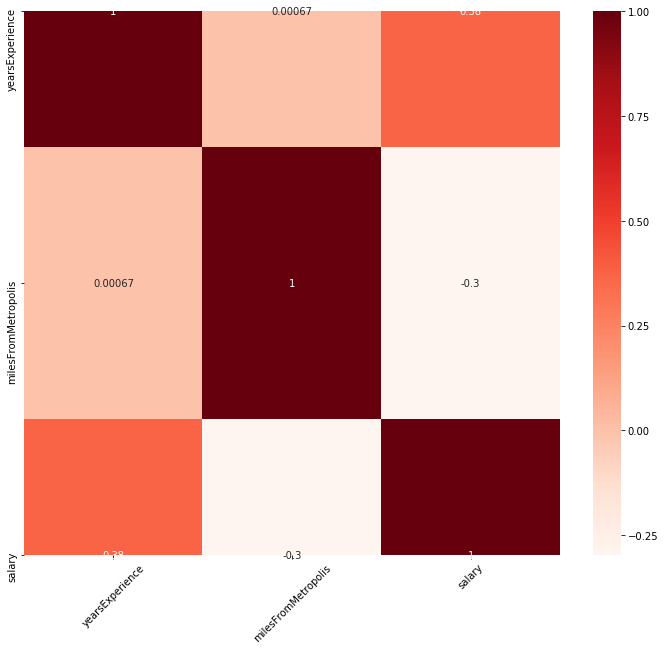

In [33]:
#look for correlation between each feature and the target
fig = plt.figure(figsize=(12, 10))
features = ['companyId', 'jobType', 'degree', 'major', 'industry', 'yearsExperience', 'milesFromMetropolis']
sns.heatmap(corr_train[features + ['salary']].corr(), cmap='Reds', annot=True)
plt.xticks(rotation=45)
plt.show()

#Feature Engineering
#one hot encode for categorical variable

In [34]:
train_feature = one_hot_encode(train_merged, cat_vars=categorical_vars, num_vars=numeric_vars)
test_feature = one_hot_encode(test_set, cat_vars=categorical_vars, num_vars=numeric_vars)

### ---- Establish a baseline (Linear Regression)----

In [35]:
# The following script divides data into attributes and labels:
X = train_feature
y = train_merged['salary']

In [36]:
# Split into training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=40)

In [37]:
# Training the Algorithm using linear regression
lr = LinearRegression()
lr.fit(X_train,y_train)
# Prediction
y_pred = lr.predict(X_test) 
y_pred

array([136.91040039, 108.71508789, 170.57763672, ..., 124.89746094,
       150.92041016, 154.39746094])

In [38]:
# Mean square error will be used to define my model performance
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))

Mean Squared Error: 386.66132421436487


#Hypothesize solution 

## DEVELOP

### ---- Create models ---- 

#### Building Random Forest Model 

In [39]:
model_1 = RandomForestRegressor(n_jobs = -1,oob_score=True, random_state=40)
# Fiting data
model_1.fit(X_train,y_train)
# Prediction
y_pred1 = model_1.predict(X_test) 
y_pred1

array([144.91866667, 104.01566667, 172.78833333, ..., 130.18      ,
       177.60741667, 146.735     ])

In [40]:
print('Mean Squared Error:', mean_squared_error(y_test, y_pred1))

Mean Squared Error: 442.3781075369192


jobType_JANITOR           0.201149
jobType_JUNIOR            0.073924
jobType_SENIOR            0.048527
jobType_MANAGER           0.027446
jobType_VICE_PRESIDENT    0.009709
jobType_CFO               0.003883
jobType_CTO               0.003899
jobType_CEO               0.008249
degree_NONE               0.005293
degree_HIGH_SCHOOL        0.003824
degree_BACHELORS          0.007509
degree_MASTERS            0.006790
degree_DOCTORAL           0.009596
major_NONE                0.054434
major_LITERATURE          0.004845
major_BIOLOGY             0.004695
major_CHEMISTRY           0.004721
major_PHYSICS             0.004653
major_COMPSCI             0.004623
major_MATH                0.005077
major_BUSINESS            0.005874
major_ENGINEERING         0.006692
industry_EDUCATION        0.029969
industry_SERVICE          0.022668
industry_AUTO             0.017221
industry_HEALTH           0.010129
industry_WEB              0.007483
industry_FINANCE          0.006588
industry_OIL        

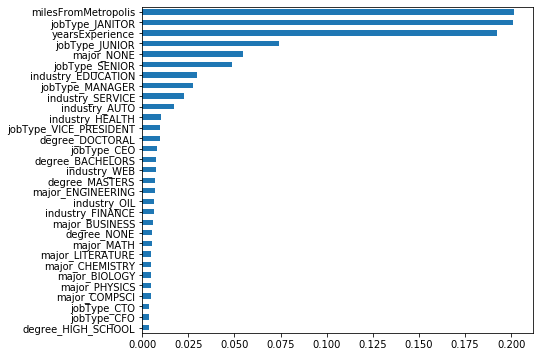

In [41]:
### Plotting feature importance
feature_importances = pd.Series(model_1.feature_importances_, index=train_feature.columns)
print(feature_importances)
feature_importances.sort_values(inplace=True)
feature_importances.plot(kind='barh', figsize=(7,6))

### Tuning Random Forest Model

C:\Users\Bal\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


1 depth
MSE Train:  295.2957433180605
MSE Test:  713.0471427452835
 


C:\Users\Bal\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


3 depth
MSE Train:  170.40599617639572
MSE Test:  532.7086962321688
 


C:\Users\Bal\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


5 depth
MSE Train:  145.45424843010113
MSE Test:  496.0880834780514
 


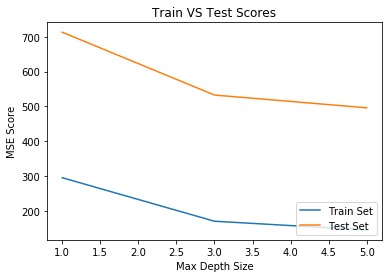

In [42]:
# Tuning max_depth_size
results  = []
results2 = []
max_depth_size  = [1,3,5]

for depth in max_depth_size:
    model = RandomForestRegressor(depth,n_jobs =-1 ,oob_score=True, random_state=44)
    #model.fit(X, y)
    model.fit(X_train, y_train)
    print(depth, 'depth')
    pred = model.predict(X_train)
    pred2 = model.predict(X_test)
    mse1 = mean_squared_error(y_train, pred)
    mse2 = mean_squared_error(y_test, pred2)
    print('MSE Train: ', mse1)
    print('MSE Test: ', mse2)
    results.append(mse1)
    results2.append(mse2)
    print (" ")

plt.plot(max_depth_size, results, label='Train Set')
plt.plot(max_depth_size, results2, label='Test Set')
plt.xlabel('Max Depth Size')
plt.ylabel('MSE Score')
plt.title('Train VS Test Scores')
plt.legend(loc="lower right")
plt.show()

C:\Users\Bal\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


1 trees
MSE Train:  296.86540255444675
MSE Test:  714.6325401922652
 


C:\Users\Bal\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


3 trees
MSE Train:  170.93170432993043
MSE Test:  530.8043558977009
 


C:\Users\Bal\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


5 trees
MSE Train:  145.72730029152018
MSE Test:  494.0874456943168
 


C:\Users\Bal\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


15 trees
MSE Train:  120.39599487108003
MSE Test:  457.56237087875553
 


C:\Users\Bal\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


20 trees
MSE Train:  117.28992841893113
MSE Test:  453.0468646212921
 


C:\Users\Bal\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


25 trees
MSE Train:  115.40551114723658
MSE Test:  450.7028526554153
 
40 trees
MSE Train:  112.62758350765421
MSE Test:  446.4107918727008
 
50 trees
MSE Train:  111.71602693099925
MSE Test:  445.3338533186499
 


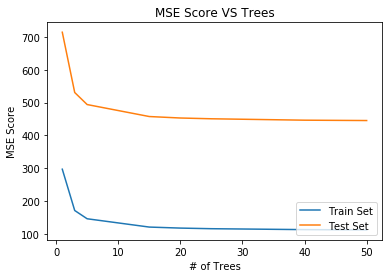

In [43]:
results = []
results2 = []
n_estimator_options = [1, 3, 5, 15, 20, 25, 40, 50]

for trees in n_estimator_options:
    model = RandomForestRegressor(trees, oob_score=True, random_state=42)
    model.fit(X_train, y_train)
    pred = model.predict(X_train)
    pred2 = model.predict(X_test)
    mse1 = mean_squared_error(y_train, pred)
    mse2 = mean_squared_error(y_test, pred2)
    
    print(trees, 'trees')
    print('MSE Train: ', mse1)
    print('MSE Test: ', mse2)
    
    results.append(mse1)
    results2.append(mse2)
    print (" ")
    
plt.plot(n_estimator_options, results, label='Train Set')
plt.plot(n_estimator_options, results2, label='Test Set')
plt.xlabel('# of Trees')
plt.ylabel('MSE Score')
plt.title('MSE Score VS Trees')
plt.legend(loc="lower right")
plt.show()

C:\Users\Bal\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


1 min samples
MSE Train:  115.40551114723658
MSE Test:  450.7028526554153
 


C:\Users\Bal\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


3 min samples
MSE Train:  213.9087557160881
MSE Test:  400.1746501685652
 


C:\Users\Bal\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


5 min samples
MSE Train:  257.6615409187843
MSE Test:  385.34574880602344
 


C:\Users\Bal\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


7 min samples
MSE Train:  280.8844249889479
MSE Test:  378.5752498672387
 


C:\Users\Bal\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


9 min samples
MSE Train:  295.35964146970565
MSE Test:  374.68773808213786
 


C:\Users\Bal\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


10 min samples
MSE Train:  300.777637032575
MSE Test:  373.51464422233227
 


C:\Users\Bal\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


20 min samples
MSE Train:  328.5439487907577
MSE Test:  369.23389897272085
 


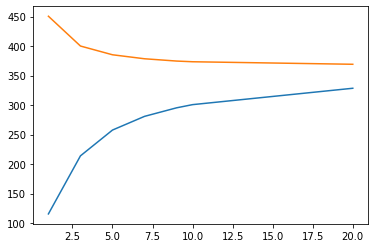

In [44]:
results_min_samples = []
results_min_samples2 = []
min_samples_leaf_options = [1, 3, 5, 7, 9, 10, 20]

for min_samples in min_samples_leaf_options:
    model = RandomForestRegressor(n_estimators=25, oob_score=True, n_jobs=-1, random_state=42, max_features="auto", min_samples_leaf=min_samples)
    model.fit(X_train, y_train)
    pred = model.predict(X_train)
    pred2 = model.predict(X_test)
    
    mse1 = mean_squared_error(y_train, pred)
    mse2 = mean_squared_error(y_test, pred2)
    
    print(min_samples, "min samples")
    print('MSE Train: ', mse1)
    print('MSE Test: ', mse2)
    results_min_samples.append(mse1)
    results_min_samples2.append(mse2)
    print (" ")
    
plt.plot(min_samples_leaf_options, results_min_samples, label='Train Set')
plt.plot(min_samples_leaf_options, results_min_samples2, label='Test Set')
plt.show()

#### Rebuild Random Forest with the updated parameters

In [45]:
model_2 = RandomForestRegressor(n_jobs = -1,oob_score=True, random_state=40,n_estimators=25, max_depth=25,min_samples_leaf =10)
model_2.fit(X_train,y_train)
y_pred2 = model_2.predict(X_test) 
print('Mean Squared Error:', mean_squared_error(y_test, y_pred2))

C:\Users\Bal\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


Mean Squared Error: 373.37273660050755


#### Tuning Gradient Boosting 

In [46]:
results_depth=[]
for depth in [2,3,4,5]:
    clf = GradientBoostingRegressor(max_depth=depth)
    clf.fit(X_train, y_train)
    results_depth.append(
        {
            'max_depth': depth,
            'train_error': mean_squared_error(y_train, clf.predict(X_train)),
            'test_error': mean_squared_error(y_test, clf.predict(X_test))
        })
    
# Display Results
max_depth_lr = pd.DataFrame(results_depth).set_index('max_depth').sort_index()
max_depth_lr

,train_error,test_error
max_depth,,
2,411.165850,414.664658
3,374.929564,378.030053
4,362.591532,365.501019
5,357.377928,360.622242


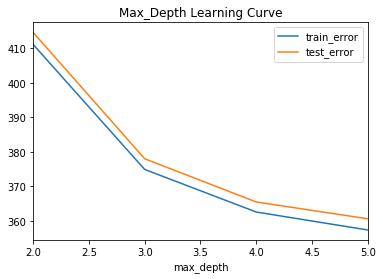

In [47]:
max_depth_lr.plot(title="Max_Depth Learning Curve")

In [48]:
results_learning=[]
for rate in [0.1,0.15,0.2,0.25,0.3]:
    clf = GradientBoostingRegressor(learning_rate=rate)
    clf.fit(X_train, y_train)
    results_learning.append(
        {
            'learning_rate': rate,
            'train_error': mean_squared_error(y_train, clf.predict(X_train)),
            'test_error': mean_squared_error(y_test, clf.predict(X_test))
        })
    
# Display Results
learning_rate_lr = pd.DataFrame(results_learning).set_index('learning_rate').sort_index()
learning_rate_lr

,train_error,test_error
learning_rate,,
0.10,374.929564,378.030053
0.15,364.013513,366.552115
0.20,361.176707,363.210084
0.25,360.622785,362.925959
0.30,359.333228,361.438818


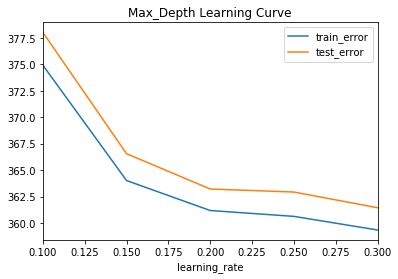

In [49]:
learning_rate_lr.plot(title="Max_Depth Learning Curve")

#### Building Gradient Boosting Model with the updated parameters

In [50]:
gbrt = GradientBoostingRegressor(max_depth=5, n_estimators=150,loss='ls',learning_rate=0.2,random_state=5)
gbrt.fit(X_train,y_train)
# Prediction
y_pred_3 = gbrt.predict(X_test) 
y_pred_3

array([147.04235151, 101.76538893, 172.53371788, ..., 127.41572493,
       153.99760972, 151.72357756])

In [51]:
print('Mean Squared Error:', mean_squared_error(y_test, y_pred_3))

Mean Squared Error: 358.4883016679009


### ----  5-Fold Cross Validation ----

In [52]:
#initialize model list and dicts
models = []
mean_mse = {}
cv_std = {}
res = {}

#define number of processes to run in parallel
num_procs = 2


In [53]:
#create models -- hyperparameter tuning already done by hand for each model
lr_cv = LinearRegression()
rf_tuned = RandomForestRegressor(n_estimators=100, n_jobs=num_procs, max_depth=25,random_state=2)
gbm_tuned = GradientBoostingRegressor(n_estimators=150, max_depth=5,learning_rate = 0.2,random_state=3)
                      
models.extend([lr_cv, rf_tuned, gbm_tuned])

#parallel cross-validate models, using MSE as evaluation metric, and print summaries
print("Beginning cross validation")
for model in models:
    train_model(model, X, y, num_procs, mean_mse, cv_std)
    print_summary(model, mean_mse, cv_std)

Beginning cross validation

Model:
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
Average MSE:
 384.5163123536564
Standard deviation during CV:
 1.3585406296258782

Model:
 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=25, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=2, oob_score=False,
                      random_state=2, verbose=0, warm_start=False)
Average MSE:
 422.6214412985119
Standard deviation during CV:
 0.9620311558590515

Model:
 GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.2, loss='ls', max_depth=5,
                          max_features=None, max_leaf_n

### ---- 10 Select best model  ----

In [54]:
#choose model with lowest mse
model = min(mean_mse, key=mean_mse.get)
print('\nPredictions calculated using model with lowest MSE:')
print_summary(model, mean_mse, cv_std)

#train model on entire dataset
model.fit(X, y)

#create predictions based on test data
predictions = model.predict(test_feature)



Predictions calculated using model with lowest MSE:

Model:
 GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.2, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=150,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=3, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
Average MSE:
 357.5663788466242
Standard deviation during CV:
 1.1169729799970582


## DEPLOY

### ---- Automate pipeline ----

In [55]:
#write script that trains model on entire training set, saves model to disk, and scores the "test" dataset
def salary_prediction_pipeline(train_df, train_target, test_df):
    
    #load data
    print('Loading data...')
    train_df = load_file(train_df)
    train_target = load_file(train_target)
    test_df = load_file(test_df)
    
    #define variables
    categorical_vars = ['companyId', 'jobType', 'degree', 'major', 'industry']
    numeric_vars = ['yearsExperience', 'milesFromMetropolis']
    target_var = 'salary'
    
    #merge data
    print('Merging data...')
    merged_df = merge_data(train_df, train_target, 'jobId')
    
    #clean data
    print('Cleaning data...')
    train_cleaned = clean_data(merged_df)
    
    #convert categorical variables to numerical for model building
    print('Converting data...')
    train_feature = one_hot_encode(train_cleaned, cat_vars=categorical_vars, num_vars=numeric_vars)
    test_feature = one_hot_encode(test_set, cat_vars=categorical_vars, num_vars=numeric_vars)

    
    #initialize model list and dicts
    print('initializing list...')
    train = train_feature
    target = train_cleaned['salary']
    test_df = test_feature
    models = []
    mean_mse = {}
    cv_std = {}
    res = {}

    #define number of processes to run in parallel
    num_procs = 2
    
    #initialize tuned models
    print('Initializing models...')
    lr = LinearRegression()
    rf = RandomForestRegressor(n_estimators=100, n_jobs=num_procs, max_depth=5)
    gbm = GradientBoostingRegressor(n_estimators=150, max_depth=5, loss='ls',learning_rate = 0.2)
    models.extend([lr, rf, gbm])

    #parallel cross-validate models, using MSE as evaluation metric, and print summaries
    print("Cross validation...")
    for model in models:
        train_model(model, train, target, num_procs, mean_mse, cv_std)
        print_summary(model, mean_mse, cv_std)
    
    #train model on entire dataset
    print("Training model...")
    model.fit(train, target)

    #create predictions based on test data
    print("Prediction...")
    predictions = model.predict(test_df)
    
    #set index to 'feature'
    print("feature importance plotting...")
    rf.fit(test_df,target)
    feature_importances = pd.Series(rf.feature_importances_, index=test_df.columns)
    print(feature_importances)
    feature_importances.sort_values(inplace=True)
    feature_importances.plot(kind='barh', figsize=(7,6))
    

    #save results
    save_results(model, mean_mse[model], predictions, feature_importances)
    
    
    

### ---- Deploy solution ----

In [ ]:
salary_prediction_pipeline("data/train_features.csv", "data/train_salaries.csv", "data/test_features.csv")

#Summary 

#Gradient Boosting is best model based on average MSE on cross-validation, which improves from 384 in the baseline model to 357 on the test data. The model tells that miles from major cities is very relevant feature in prediction. 